In [1]:
import numpy as np
from scipy.sparse import *
from sklearn.metrics.pairwise import pairwise_distances


def construct_W(X, **kwargs):
    """
    Construct the affinity matrix W through different ways

    Notes
    -----
    if kwargs is null, use the default parameter settings;
    if kwargs is not null, construct the affinity matrix according to parameters in kwargs

    Input
    -----
    X: {numpy array}, shape (n_samples, n_features)
        input data
    kwargs: {dictionary}
        parameters to construct different affinity matrix W:
        y: {numpy array}, shape (n_samples, 1)
            the true label information needed under the 'supervised' neighbor mode
        metric: {string}
            choices for different distance measures
            'euclidean' - use euclidean distance
            'cosine' - use cosine distance (default)
        neighbor_mode: {string}
            indicates how to construct the graph
            'knn' - put an edge between two nodes if and only if they are among the
                    k nearest neighbors of each other (default)
            'supervised' - put an edge between two nodes if they belong to same class
                    and they are among the k nearest neighbors of each other
        weight_mode: {string}
            indicates how to assign weights for each edge in the graph
            'binary' - 0-1 weighting, every edge receives weight of 1 (default)
            'heat_kernel' - if nodes i and j are connected, put weight W_ij = exp(-norm(x_i - x_j)/2t^2)
                            this weight mode can only be used under 'euclidean' metric and you are required
                            to provide the parameter t
            'cosine' - if nodes i and j are connected, put weight cosine(x_i,x_j).
                        this weight mode can only be used under 'cosine' metric
        k: {int}
            choices for the number of neighbors (default k = 5)
        t: {float}
            parameter for the 'heat_kernel' weight_mode
        fisher_score: {boolean}
            indicates whether to build the affinity matrix in a fisher score way, in which W_ij = 1/n_l if yi = yj = l;
            otherwise W_ij = 0 (default fisher_score = false)
        reliefF: {boolean}
            indicates whether to build the affinity matrix in a reliefF way, NH(x) and NM(x,y) denotes a set of
            k nearest points to x with the same class as x, and a different class (the class y), respectively.
            W_ij = 1 if i = j; W_ij = 1/k if x_j \in NH(x_i); W_ij = -1/(c-1)k if x_j \in NM(x_i, y) (default reliefF = false)

    Output
    ------
    W: {sparse matrix}, shape (n_samples, n_samples)
        output affinity matrix W
    """

    # default metric is 'cosine'
    if 'metric' not in kwargs.keys():
        kwargs['metric'] = 'cosine'

    # default neighbor mode is 'knn' and default neighbor size is 5
    if 'neighbor_mode' not in kwargs.keys():
        kwargs['neighbor_mode'] = 'knn'
    if kwargs['neighbor_mode'] == 'knn' and 'k' not in kwargs.keys():
        kwargs['k'] = 5
    if kwargs['neighbor_mode'] == 'supervised' and 'k' not in kwargs.keys():
        kwargs['k'] = 5
    if kwargs['neighbor_mode'] == 'supervised' and 'y' not in kwargs.keys():
        print ('Warning: label is required in the supervised neighborMode!!!')
        exit(0)

    # default weight mode is 'binary', default t in heat kernel mode is 1
    if 'weight_mode' not in kwargs.keys():
        kwargs['weight_mode'] = 'binary'
    if kwargs['weight_mode'] == 'heat_kernel':
        if kwargs['metric'] != 'euclidean':
            kwargs['metric'] = 'euclidean'
        if 't' not in kwargs.keys():
            kwargs['t'] = 1
    elif kwargs['weight_mode'] == 'cosine':
        if kwargs['metric'] != 'cosine':
            kwargs['metric'] = 'cosine'

    # default fisher_score and reliefF mode are 'false'
    if 'fisher_score' not in kwargs.keys():
        kwargs['fisher_score'] = False
    if 'reliefF' not in kwargs.keys():
        kwargs['reliefF'] = False

    n_samples, n_features = np.shape(X)

    # choose 'knn' neighbor mode
    if kwargs['neighbor_mode'] == 'knn':
        k = kwargs['k']
        if kwargs['weight_mode'] == 'binary':
            if kwargs['metric'] == 'euclidean':
                # compute pairwise euclidean distances
                D = pairwise_distances(X)
                D **= 2
                # sort the distance matrix D in ascending order
                dump = np.sort(D, axis=1)
                idx = np.argsort(D, axis=1)
                # choose the k-nearest neighbors for each instance
                idx_new = idx[:, 0:k+1]
                G = np.zeros((n_samples*(k+1), 3))
                G[:, 0] = np.tile(np.arange(n_samples), (k+1, 1)).reshape(-1)
                G[:, 1] = np.ravel(idx_new, order='F')
                G[:, 2] = 1
                # build the sparse affinity matrix W
                W = csc_matrix((G[:, 2], (G[:, 0], G[:, 1])), shape=(n_samples, n_samples))
                bigger = np.transpose(W) > W
                W = W - W.multiply(bigger) + np.transpose(W).multiply(bigger)
                return W

            elif kwargs['metric'] == 'cosine':
                # normalize the data first
                X_normalized = np.power(np.sum(X*X, axis=1), 0.5)
                for i in range(n_samples):
                    X[i, :] = X[i, :]/max(1e-12, X_normalized[i])
                # compute pairwise cosine distances
                D_cosine = np.dot(X, np.transpose(X))
                # sort the distance matrix D in descending order
                dump = np.sort(-D_cosine, axis=1)
                idx = np.argsort(-D_cosine, axis=1)
                idx_new = idx[:, 0:k+1]
                G = np.zeros((n_samples*(k+1), 3))
                G[:, 0] = np.tile(np.arange(n_samples), (k+1, 1)).reshape(-1)
                G[:, 1] = np.ravel(idx_new, order='F')
                G[:, 2] = 1
                # build the sparse affinity matrix W
                W = csc_matrix((G[:, 2], (G[:, 0], G[:, 1])), shape=(n_samples, n_samples))
                bigger = np.transpose(W) > W
                W = W - W.multiply(bigger) + np.transpose(W).multiply(bigger)
                return W

        elif kwargs['weight_mode'] == 'heat_kernel':
            t = kwargs['t']
            # compute pairwise euclidean distances
            D = pairwise_distances(X)
            D **= 2
            # sort the distance matrix D in ascending order
            dump = np.sort(D, axis=1)
            idx = np.argsort(D, axis=1)
            idx_new = idx[:, 0:k+1]
            dump_new = dump[:, 0:k+1]
            # compute the pairwise heat kernel distances
            dump_heat_kernel = np.exp(-dump_new/(2*t*t))
            G = np.zeros((n_samples*(k+1), 3))
            G[:, 0] = np.tile(np.arange(n_samples), (k+1, 1)).reshape(-1)
            G[:, 1] = np.ravel(idx_new, order='F')
            G[:, 2] = np.ravel(dump_heat_kernel, order='F')
            # build the sparse affinity matrix W
            W = csc_matrix((G[:, 2], (G[:, 0], G[:, 1])), shape=(n_samples, n_samples))
            bigger = np.transpose(W) > W
            W = W - W.multiply(bigger) + np.transpose(W).multiply(bigger)
            return W

        elif kwargs['weight_mode'] == 'cosine':
            # normalize the data first
            X_normalized = np.power(np.sum(X*X, axis=1), 0.5)
            for i in range(n_samples):
                    X[i, :] = X[i, :]/max(1e-12, X_normalized[i])
            # compute pairwise cosine distances
            D_cosine = np.dot(X, np.transpose(X))
            # sort the distance matrix D in ascending order
            dump = np.sort(-D_cosine, axis=1)
            idx = np.argsort(-D_cosine, axis=1)
            idx_new = idx[:, 0:k+1]
            dump_new = -dump[:, 0:k+1]
            G = np.zeros((n_samples*(k+1), 3))
            G[:, 0] = np.tile(np.arange(n_samples), (k+1, 1)).reshape(-1)
            G[:, 1] = np.ravel(idx_new, order='F')
            G[:, 2] = np.ravel(dump_new, order='F')
            # build the sparse affinity matrix W
            W = csc_matrix((G[:, 2], (G[:, 0], G[:, 1])), shape=(n_samples, n_samples))
            bigger = np.transpose(W) > W
            W = W - W.multiply(bigger) + np.transpose(W).multiply(bigger)
            return W

    # choose supervised neighborMode
    elif kwargs['neighbor_mode'] == 'supervised':
        k = kwargs['k']
        # get true labels and the number of classes
        y = kwargs['y']
        label = np.unique(y)
        n_classes = np.unique(y).size
        # construct the weight matrix W in a fisherScore way, W_ij = 1/n_l if yi = yj = l, otherwise W_ij = 0
        if kwargs['fisher_score'] is True:
            W = lil_matrix((n_samples, n_samples))
            for i in range(n_classes):
                class_idx = (y == label[i])
                class_idx_all = (class_idx[:, np.newaxis] & class_idx[np.newaxis, :])
                W[class_idx_all] = 1.0/np.sum(np.sum(class_idx))
            return W

        # construct the weight matrix W in a reliefF way, NH(x) and NM(x,y) denotes a set of k nearest
        # points to x with the same class as x, a different class (the class y), respectively. W_ij = 1 if i = j;
        # W_ij = 1/k if x_j \in NH(x_i); W_ij = -1/(c-1)k if x_j \in NM(x_i, y)
        if kwargs['reliefF'] is True:
            # when xj in NH(xi)
            G = np.zeros((n_samples*(k+1), 3))
            id_now = 0
            for i in range(n_classes):
                class_idx = np.column_stack(np.where(y == label[i]))[:, 0]
                D = pairwise_distances(X[class_idx, :])
                D **= 2
                idx = np.argsort(D, axis=1)
                idx_new = idx[:, 0:k+1]
                n_smp_class = (class_idx[idx_new[:]]).size
                if len(class_idx) <= k:
                    k = len(class_idx) - 1
                G[id_now:n_smp_class+id_now, 0] = np.tile(class_idx, (k+1, 1)).reshape(-1)
                G[id_now:n_smp_class+id_now, 1] = np.ravel(class_idx[idx_new[:]], order='F')
                G[id_now:n_smp_class+id_now, 2] = 1.0/k
                id_now += n_smp_class
            W1 = csc_matrix((G[:, 2], (G[:, 0], G[:, 1])), shape=(n_samples, n_samples))
            # when i = j, W_ij = 1
            for i in range(n_samples):
                W1[i, i] = 1
            # when x_j in NM(x_i, y)
            G = np.zeros((n_samples*k*(n_classes - 1), 3))
            id_now = 0
            for i in range(n_classes):
                class_idx1 = np.column_stack(np.where(y == label[i]))[:, 0]
                X1 = X[class_idx1, :]
                for j in range(n_classes):
                    if label[j] != label[i]:
                        class_idx2 = np.column_stack(np.where(y == label[j]))[:, 0]
                        X2 = X[class_idx2, :]
                        D = pairwise_distances(X1, X2)
                        idx = np.argsort(D, axis=1)
                        idx_new = idx[:, 0:k]
                        n_smp_class = len(class_idx1)*k
                        G[id_now:n_smp_class+id_now, 0] = np.tile(class_idx1, (k, 1)).reshape(-1)
                        G[id_now:n_smp_class+id_now, 1] = np.ravel(class_idx2[idx_new[:]], order='F')
                        G[id_now:n_smp_class+id_now, 2] = -1.0/((n_classes-1)*k)
                        id_now += n_smp_class
            W2 = csc_matrix((G[:, 2], (G[:, 0], G[:, 1])), shape=(n_samples, n_samples))
            bigger = np.transpose(W2) > W2
            W2 = W2 - W2.multiply(bigger) + np.transpose(W2).multiply(bigger)
            W = W1 + W2
            return W

        if kwargs['weight_mode'] == 'binary':
            if kwargs['metric'] == 'euclidean':
                G = np.zeros((n_samples*(k+1), 3))
                id_now = 0
                for i in range(n_classes):
                    class_idx = np.column_stack(np.where(y == label[i]))[:, 0]
                    # compute pairwise euclidean distances for instances in class i
                    D = pairwise_distances(X[class_idx, :])
                    D **= 2
                    # sort the distance matrix D in ascending order for instances in class i
                    idx = np.argsort(D, axis=1)
                    idx_new = idx[:, 0:k+1]
                    n_smp_class = len(class_idx)*(k+1)
                    G[id_now:n_smp_class+id_now, 0] = np.tile(class_idx, (k+1, 1)).reshape(-1)
                    G[id_now:n_smp_class+id_now, 1] = np.ravel(class_idx[idx_new[:]], order='F')
                    G[id_now:n_smp_class+id_now, 2] = 1
                    id_now += n_smp_class
                # build the sparse affinity matrix W
                W = csc_matrix((G[:, 2], (G[:, 0], G[:, 1])), shape=(n_samples, n_samples))
                bigger = np.transpose(W) > W
                W = W - W.multiply(bigger) + np.transpose(W).multiply(bigger)
                return W

            if kwargs['metric'] == 'cosine':
                # normalize the data first
                X_normalized = np.power(np.sum(X*X, axis=1), 0.5)
                for i in range(n_samples):
                    X[i, :] = X[i, :]/max(1e-12, X_normalized[i])
                G = np.zeros((n_samples*(k+1), 3))
                id_now = 0
                for i in range(n_classes):
                    class_idx = np.column_stack(np.where(y == label[i]))[:, 0]
                    # compute pairwise cosine distances for instances in class i
                    D_cosine = np.dot(X[class_idx, :], np.transpose(X[class_idx, :]))
                    # sort the distance matrix D in descending order for instances in class i
                    idx = np.argsort(-D_cosine, axis=1)
                    idx_new = idx[:, 0:k+1]
                    n_smp_class = len(class_idx)*(k+1)
                    G[id_now:n_smp_class+id_now, 0] = np.tile(class_idx, (k+1, 1)).reshape(-1)
                    G[id_now:n_smp_class+id_now, 1] = np.ravel(class_idx[idx_new[:]], order='F')
                    G[id_now:n_smp_class+id_now, 2] = 1
                    id_now += n_smp_class
                # build the sparse affinity matrix W
                W = csc_matrix((G[:, 2], (G[:, 0], G[:, 1])), shape=(n_samples, n_samples))
                bigger = np.transpose(W) > W
                W = W - W.multiply(bigger) + np.transpose(W).multiply(bigger)
                return W

        elif kwargs['weight_mode'] == 'heat_kernel':
            G = np.zeros((n_samples*(k+1), 3))
            id_now = 0
            for i in range(n_classes):
                class_idx = np.column_stack(np.where(y == label[i]))[:, 0]
                # compute pairwise cosine distances for instances in class i
                D = pairwise_distances(X[class_idx, :])
                D **= 2
                # sort the distance matrix D in ascending order for instances in class i
                dump = np.sort(D, axis=1)
                idx = np.argsort(D, axis=1)
                idx_new = idx[:, 0:k+1]
                dump_new = dump[:, 0:k+1]
                t = kwargs['t']
                # compute pairwise heat kernel distances for instances in class i
                dump_heat_kernel = np.exp(-dump_new/(2*t*t))
                n_smp_class = len(class_idx)*(k+1)
                G[id_now:n_smp_class+id_now, 0] = np.tile(class_idx, (k+1, 1)).reshape(-1)
                G[id_now:n_smp_class+id_now, 1] = np.ravel(class_idx[idx_new[:]], order='F')
                G[id_now:n_smp_class+id_now, 2] = np.ravel(dump_heat_kernel, order='F')
                id_now += n_smp_class
            # build the sparse affinity matrix W
            W = csc_matrix((G[:, 2], (G[:, 0], G[:, 1])), shape=(n_samples, n_samples))
            bigger = np.transpose(W) > W
            W = W - W.multiply(bigger) + np.transpose(W).multiply(bigger)
            return W

        elif kwargs['weight_mode'] == 'cosine':
            # normalize the data first
            X_normalized = np.power(np.sum(X*X, axis=1), 0.5)
            for i in range(n_samples):
                X[i, :] = X[i, :]/max(1e-12, X_normalized[i])
            G = np.zeros((n_samples*(k+1), 3))
            id_now = 0
            for i in range(n_classes):
                class_idx = np.column_stack(np.where(y == label[i]))[:, 0]
                # compute pairwise cosine distances for instances in class i
                D_cosine = np.dot(X[class_idx, :], np.transpose(X[class_idx, :]))
                # sort the distance matrix D in descending order for instances in class i
                dump = np.sort(-D_cosine, axis=1)
                idx = np.argsort(-D_cosine, axis=1)
                idx_new = idx[:, 0:k+1]
                dump_new = -dump[:, 0:k+1]
                n_smp_class = len(class_idx)*(k+1)
                G[id_now:n_smp_class+id_now, 0] = np.tile(class_idx, (k+1, 1)).reshape(-1)
                G[id_now:n_smp_class+id_now, 1] = np.ravel(class_idx[idx_new[:]], order='F')
                G[id_now:n_smp_class+id_now, 2] = np.ravel(dump_new, order='F')
                id_now += n_smp_class
            # build the sparse affinity matrix W
            W = csc_matrix((G[:, 2], (G[:, 0], G[:, 1])), shape=(n_samples, n_samples))
            bigger = np.transpose(W) > W
            W = W - W.multiply(bigger) + np.transpose(W).multiply(bigger)
            return W

<>:7: SyntaxWarning: invalid escape sequence '\i'
<>:7: SyntaxWarning: invalid escape sequence '\i'
/var/folders/v8/yj_gmdgd47l6hvz6s8ldkqfc0000gn/T/ipykernel_59962/3265394307.py:7: SyntaxWarning: invalid escape sequence '\i'
  """


## Open Data

In [ ]:
# Download latest version
import kagglehub
path = kagglehub.dataset_download("uciml/human-activity-recognition-with-smartphones")
print("Path to dataset files:", path)

In [64]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import accuracy_score
from sklearn.metrics.pairwise import rbf_kernel
from scipy.sparse import diags
from sklearn.linear_model import Lasso
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# Load the train and test datasets
#data_train = pd.read_csv('/Users/ludoviclepic/.cache/kagglehub/datasets/uciml/human-activity-recognition-with-smartphones/versions/2/train.csv')
#data_test = pd.read_csv('/Users/ludoviclepic/.cache/kagglehub/datasets/uciml/human-activity-recognition-with-smartphones/versions/2/test.csv')
data_train = pd.read_csv(f"{path}/train.csv")
data_test = pd.read_csv(f"{path}test.csv")


# Split features and target for both train and test
X_train = data_train.iloc[:, :-1]
y_train = data_train.iloc[:, -1]
X_test = data_test.iloc[:, :-1]
y_test = data_test.iloc[:, -1]

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## All features

In [3]:
# Train on all features
classifier_all = RandomForestClassifier(random_state=42, class_weight="balanced")
classifier_all.fit(X_scaled, y_encoded)
X_test_scaled = scaler.transform(X_test)
y_pred_all = classifier_all.predict(X_test_scaled)

# Evaluate accuracy
accuracy_all_features = accuracy_score(y_test_encoded, y_pred_all)
print(f"Accuracy using all {X_test.shape} Features: {accuracy_all_features:.2f}")


Accuracy using all (2947, 562) Features: 0.93


## Similarity

### Laplacian Score

In [65]:
def lap_score(X, **kwargs):
    """
    This function implements the laplacian score feature selection, steps are as follows:
    1. Construct the affinity matrix W if it is not specified
    2. For the r-th feature, we define fr = X(:,r), D = diag(W*ones), ones = [1,...,1]', L = D - W
    3. Let fr_hat = fr - (fr'*D*ones)*ones/(ones'*D*ones)
    4. Laplacian score for the r-th feature is score = (fr_hat'*L*fr_hat)/(fr_hat'*D*fr_hat)

    Input
    -----
    X: {numpy array}, shape (n_samples, n_features)
        input data
    kwargs: {dictionary}
        W: {sparse matrix}, shape (n_samples, n_samples)
            input affinity matrix

    Output
    ------
    score: {numpy array}, shape (n_features,)
        laplacian score for each feature

    Reference
    ---------
    He, Xiaofei et al. "Laplacian Score for Feature Selection." NIPS 2005.
    """

    # if 'W' is not specified, use the default W
    if 'W' not in kwargs.keys():
        W = construct_W(X)
    # construct the affinity matrix W
    W = kwargs['W']
    # build the diagonal D matrix from affinity matrix W
    D = np.array(W.sum(axis=1))
    L = W
    tmp = np.dot(np.transpose(D), X)
    D = diags(np.transpose(D), [0])
    Xt = np.transpose(X)
    t1 = np.transpose(np.dot(Xt, D.todense()))
    t2 = np.transpose(np.dot(Xt, L.todense()))
    # compute the numerator of Lr
    D_prime = np.sum(np.multiply(t1, X), 0) - np.multiply(tmp, tmp)/D.sum()
    # compute the denominator of Lr
    L_prime = np.sum(np.multiply(t2, X), 0) - np.multiply(tmp, tmp)/D.sum()
    # avoid the denominator of Lr to be 0
    D_prime[D_prime < 1e-12] = 10000

    # compute laplacian score for all features
    score = 1 - np.array(np.multiply(L_prime, 1/D_prime))[0, :]
    return np.transpose(score)


def feature_ranking(score):
    """
    Rank features in ascending order according to their laplacian scores, the smaller the laplacian score is, the more
    important the feature is
    """
    idx = np.argsort(score, 0)
    return idx

In [74]:
from IPython.display import clear_output
W = construct_W(X_scaled)  # Affinity matrix
laplacian_scores = lap_score(X_scaled, W=W)
ranked_features = feature_ranking(laplacian_scores)

Accuracy with top 551 features: 0.66


<Figure size 640x480 with 0 Axes>

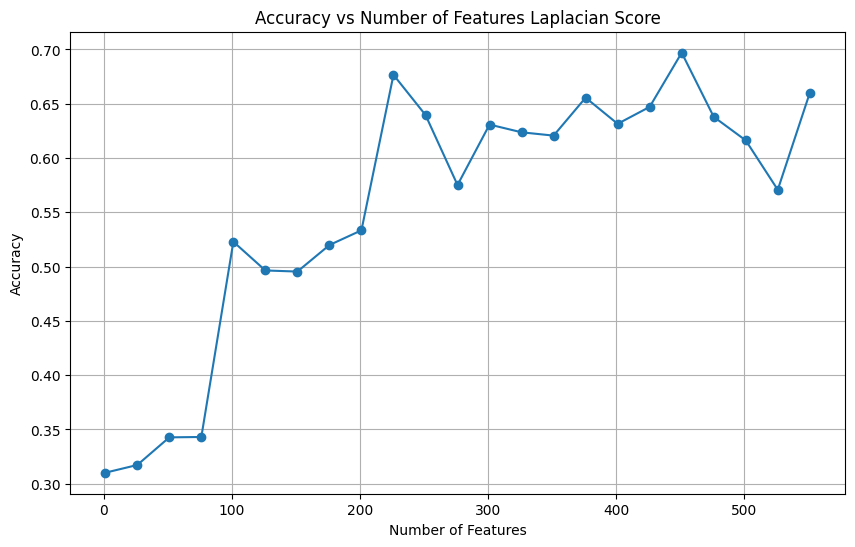

Best number of features: 451
Best accuracy: 0.70


In [73]:
best_accuracy = 0
best_num_features = 0
best_model = None

num_features_list = []
accuracy_list = []

for num_features in range(1, len(ranked_features) + 1, 25):
    top_laplacian_features = ranked_features[:num_features]
    
    # Subset the train and test data with top Laplacian features
    X_train_laplacian = X_scaled[:, top_laplacian_features]
    X_test_laplacian = X_test_scaled[:, top_laplacian_features]
    
    # Train and evaluate the classifier
    classifier = RandomForestClassifier(random_state=42, class_weight="balanced")
    classifier.fit(X_train_laplacian, y_encoded)
    y_pred_laplacian = classifier.predict(X_test_laplacian)
    
    # Evaluate accuracy
    accuracy_laplacian = accuracy_score(y_test_encoded, y_pred_laplacian)
    clear_output(wait=True)
    print(f"Accuracy with top {num_features} features: {accuracy_laplacian:.2f}")

    num_features_list.append(num_features)
    accuracy_list.append(accuracy_laplacian)

    plt.clf()
    plt.figure(figsize=(10, 6))
    plt.xlabel('Number of Features')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs Number of Features Laplacian Score')
    plt.grid(True)
    plt.plot(num_features_list, accuracy_list, marker='o')
    
    # Track the best model
    if accuracy_laplacian > best_accuracy:
        best_accuracy = accuracy_laplacian
        best_num_features = num_features
        best_model = classifier
    plt.show()

print(f"Best number of features: {best_num_features}")
print(f"Best accuracy: {best_accuracy:.2f}")

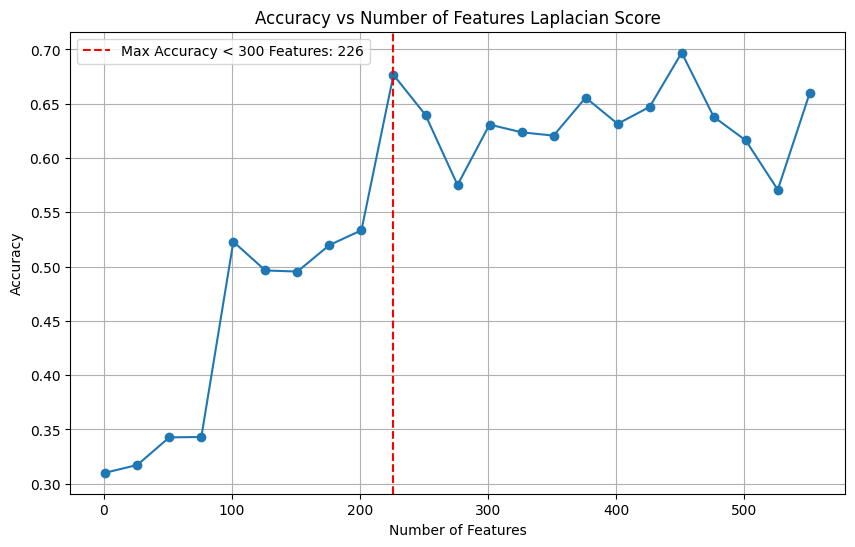

In [85]:
max_accuracy_2_lap = 0
best_num_features_2_lap = 0
for num_features, accuracy in zip(num_features_list, accuracy_list):
    if num_features < 300 and accuracy > max_accuracy_2_lap:
        max_accuracy_2_lap = accuracy
        best_num_features_2_lap = num_features

# Plot the final graph with vertical line
plt.figure(figsize=(10, 6))
plt.xlabel('Number of Features')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Number of Features Laplacian Score')
plt.grid(True)
plt.plot(num_features_list, accuracy_list, marker='o')
plt.axvline(x=best_num_features_2_lap, color='r', linestyle='--', label=f'Max Accuracy < 300 Features: {best_num_features_2_lap:.0f}')
plt.legend()
plt.show()

### Fisher Score

In [9]:
def fisher_score(X, y):
    """
    This function implements the fisher score feature selection, steps are as follows:
    1. Construct the affinity matrix W in fisher score way
    2. For the r-th feature, we define fr = X(:,r), D = diag(W*ones), ones = [1,...,1]', L = D - W
    3. Let fr_hat = fr - (fr'*D*ones)*ones/(ones'*D*ones)
    4. Fisher score for the r-th feature is score = (fr_hat'*D*fr_hat)/(fr_hat'*L*fr_hat)-1

    Input
    -----
    X: {numpy array}, shape (n_samples, n_features)
        input data
    y: {numpy array}, shape (n_samples,)
        input class labels

    Output
    ------
    score: {numpy array}, shape (n_features,)
        fisher score for each feature

    Reference
    ---------
    He, Xiaofei et al. "Laplacian Score for Feature Selection." NIPS 2005.
    Duda, Richard et al. "Pattern classification." John Wiley & Sons, 2012.
    """

    # Construct weight matrix W in a fisherScore way
    kwargs = {"neighbor_mode": "supervised", "fisher_score": True, 'y': y}
    W = construct_W(X, **kwargs)

    # build the diagonal D matrix from affinity matrix W
    D = np.array(W.sum(axis=1))
    L = W
    tmp = np.dot(np.transpose(D), X)
    D = diags(np.transpose(D), [0])
    Xt = np.transpose(X)
    t1 = np.transpose(np.dot(Xt, D.todense()))
    t2 = np.transpose(np.dot(Xt, L.todense()))
    # compute the numerator of Lr
    D_prime = np.sum(np.multiply(t1, X), 0) - np.multiply(tmp, tmp)/D.sum()
    # compute the denominator of Lr
    L_prime = np.sum(np.multiply(t2, X), 0) - np.multiply(tmp, tmp)/D.sum()
    # avoid the denominator of Lr to be 0
    D_prime[D_prime < 1e-12] = 10000
    lap_score = 1 - np.array(np.multiply(L_prime, 1/D_prime))[0, :]

    # compute fisher score from laplacian score, where fisher_score = 1/lap_score - 1
    score = 1.0/lap_score - 1
    return np.transpose(score)


def feature_ranking(score):
    """
    Rank features in descending order according to fisher score, the larger the fisher score, the more important the
    feature is
    """
    idx = np.argsort(score, 0)
    return idx[::-1]

In [75]:
# Fisher Score Pipeline
# Compute Fisher Scores for the dataset
fisher_scores = fisher_score(X_scaled, y_encoded)
ranked_features_fisher = feature_ranking(fisher_scores)

Accuracy using Fisher-Selected Features: 0.60


<Figure size 640x480 with 0 Axes>

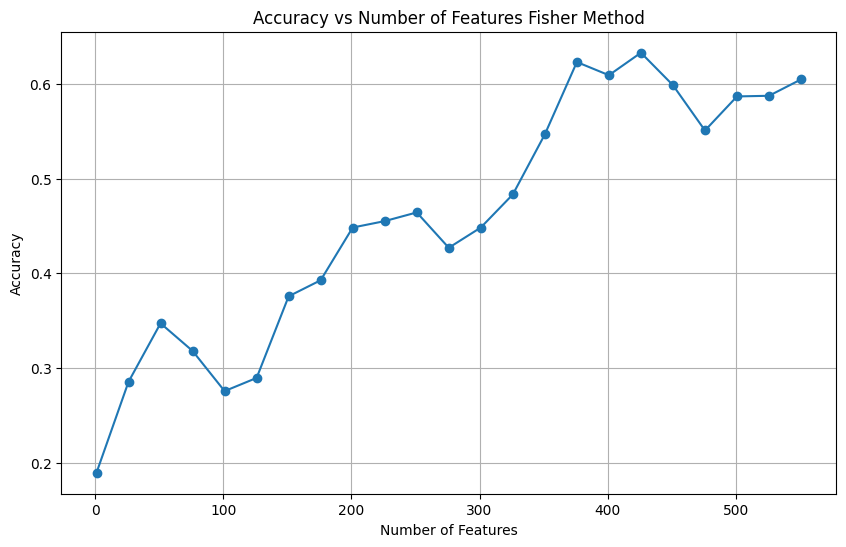

Best number of features: 426
Best accuracy: 0.63


In [72]:
best_accuracy_fisher = 0
best_num_features_fisher = 0
best_model_fisher = None

num_features_list_fisher = []
accuracy_list_fisher = []

for num_features in range(1, len(ranked_features) + 1, 25):
    top_fisher_features = ranked_features_fisher[:num_features]
    #print("Top Fisher Features:", top_fisher_features)

    # Subset the train and test data with top Fisher features
    X_train_fisher = X_scaled[:, top_fisher_features]
    X_test_fisher = X_test_scaled[:, top_fisher_features]

    # Train and evaluate the classifier
    classifier = RandomForestClassifier(random_state=42, class_weight="balanced")
    classifier.fit(X_train_fisher, y_encoded)
    y_pred_fisher = classifier.predict(X_test_fisher)

    # Evaluate accuracy
    accuracy_fisher = accuracy_score(y_test_encoded, y_pred_fisher)
    clear_output(wait=True)
    print(f"Accuracy using Fisher-Selected Features: {accuracy_fisher:.2f}")

    num_features_list_fisher.append(num_features)
    accuracy_list_fisher.append(accuracy_fisher)

    plt.clf()
    plt.figure(figsize=(10, 6))
    plt.xlabel('Number of Features')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs Number of Features Fisher Method')
    plt.grid(True)
    plt.plot(num_features_list_fisher, accuracy_list_fisher, marker='o')

    if accuracy_fisher > best_accuracy_fisher:
        best_accuracy_fisher = accuracy_fisher
        best_num_features_fisher = num_features
        best_model_fisher = classifier
    plt.show()

print(f"Best number of features: {best_num_features_fisher}")
print(f"Best accuracy: {best_accuracy_fisher:.2f}")


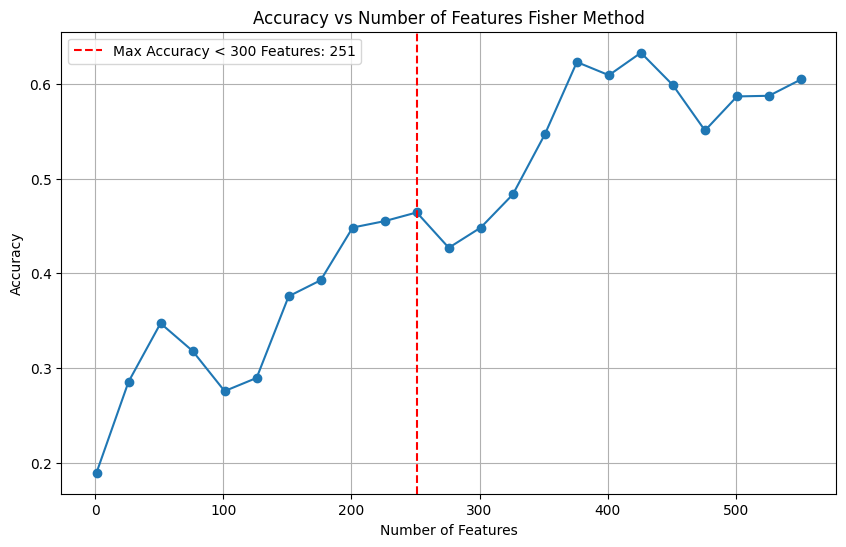

In [86]:
max_accuracy_2_fisher = 0
best_num_features_under_300 = 0
for num_features, accuracy in zip(num_features_list_fisher, accuracy_list_fisher):
    if num_features < 300 and accuracy > max_accuracy_under_300:
        max_accuracy_under_300 = accuracy
        best_num_features_under_300 = num_features

# Plot the final graph with vertical line
plt.figure(figsize=(10, 6))
plt.xlabel('Number of Features')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Number of Features Fisher Method')
plt.grid(True)
plt.plot(num_features_list_fisher, accuracy_list_fisher, marker='o')
plt.axvline(x=best_num_features_under_300, color='r', linestyle='--', label=f'Max Accuracy < 300 Features: {best_num_features_under_300:.0f}')
plt.legend()
plt.show()

## Theoretical Information Based

### CMIM

In [35]:
from sklearn.feature_selection import mutual_info_classif
import numpy as np

def cmim(X, y, n_selected_features):
    """
    Perform Conditional Mutual Information Maximization (CMIM) for feature selection.

    Parameters:
    - X: ndarray of shape (n_samples, n_features)
        Feature matrix.
    - y: ndarray of shape (n_samples,)
        Target vector.
    - n_selected_features: int
        Number of features to select.

    Returns:
    - selected_features: list of int
        Indices of the selected features.
    - scores: list of float
        Scores of the selected features.
    - remaining_features: list of int
        Indices of features that were not selected.
    """
    n_samples, n_features = X.shape
    selected_features = []
    remaining_features = list(range(n_features))
    scores = []

    # Compute mutual information between each feature and the target
    mi = mutual_info_classif(X, y)

    for _ in range(n_selected_features):
        best_feature = None
        best_score = -np.inf

        for feature in remaining_features:
            min_cmi = np.inf  # Initialize the conditional mutual information to a high value

            # Calculate conditional mutual information with previously selected features
            for selected_feature in selected_features:
                cmi = mi[feature] - (np.abs(np.corrcoef(X[:, feature], X[:, selected_feature])[0, 1]) * mi[selected_feature])
                min_cmi = min(min_cmi, cmi)

            # Update the best feature based on the maximum minimum conditional mutual information
            if min_cmi > best_score:
                best_score = min_cmi
                best_feature = feature

        # Update the selected features, remaining features, and scores
        selected_features.append(best_feature)
        remaining_features.remove(best_feature)
        scores.append(best_score)

    return selected_features, scores, remaining_features


In [76]:
# CMIM Feature Selection Pipeline
# Compute CMIM Scores for the dataset
num_features_to_test = len(X_scaled[0])  # You can reduce this if testing all features is too costly
selected_features_cmim, _, _ = cmim(X_scaled, y_encoded, n_selected_features=num_features_to_test)

Accuracy using CMIM-Selected Features: 0.67


<Figure size 640x480 with 0 Axes>

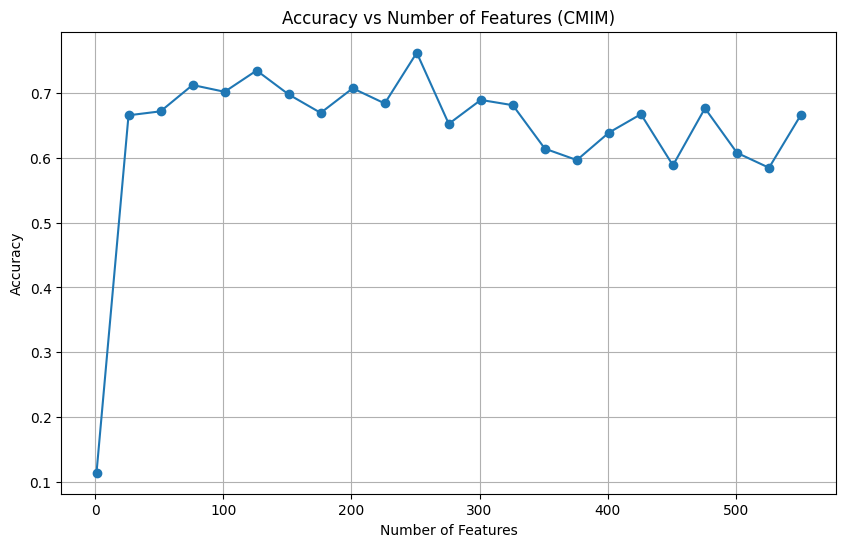

Best number of features (CMIM): 251
Best accuracy (CMIM): 0.76


In [71]:
best_accuracy_cmim = 0
best_num_features_cmim = 0
best_model_cmim = None

num_features_list_cmim = []
accuracy_list_cmim = []

# Iterate through the number of selected features
for num_features in range(1, len(selected_features_cmim) + 1, 25):  # Adjust step size as needed
    top_cmim_features = selected_features_cmim[:num_features]
    print(top_cmim_features)
    # Subset the train and test data with top CMIM features
    X_train_cmim = X_scaled[:, top_cmim_features]
    X_test_scaled = scaler.transform(X_test)
    X_test_cmim = X_test_scaled[:, top_cmim_features]

    # Train and evaluate the classifier
    classifier = RandomForestClassifier(random_state=42, class_weight="balanced")
    classifier.fit(X_train_cmim, y_encoded)
    y_pred_cmim = classifier.predict(X_test_cmim)

    # Evaluate accuracy
    accuracy_cmim = accuracy_score(y_test_encoded, y_pred_cmim)
    clear_output(wait=True)
    print(f"Accuracy using CMIM-Selected Features: {accuracy_cmim:.2f}")

    num_features_list_cmim.append(num_features)
    accuracy_list_cmim.append(accuracy_cmim)

    plt.clf()
    plt.figure(figsize=(10, 6))
    plt.xlabel('Number of Features')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs Number of Features (CMIM)')
    plt.grid(True)
    plt.plot(num_features_list_cmim, accuracy_list_cmim, marker='o')

    if accuracy_cmim > best_accuracy_cmim:
        best_accuracy_cmim = accuracy_cmim
        best_num_features_cmim = num_features
        best_model_cmim = classifier
    plt.show()

print(f"Best number of features (CMIM): {best_num_features_cmim}")
print(f"Best accuracy (CMIM): {best_accuracy_cmim:.2f}")


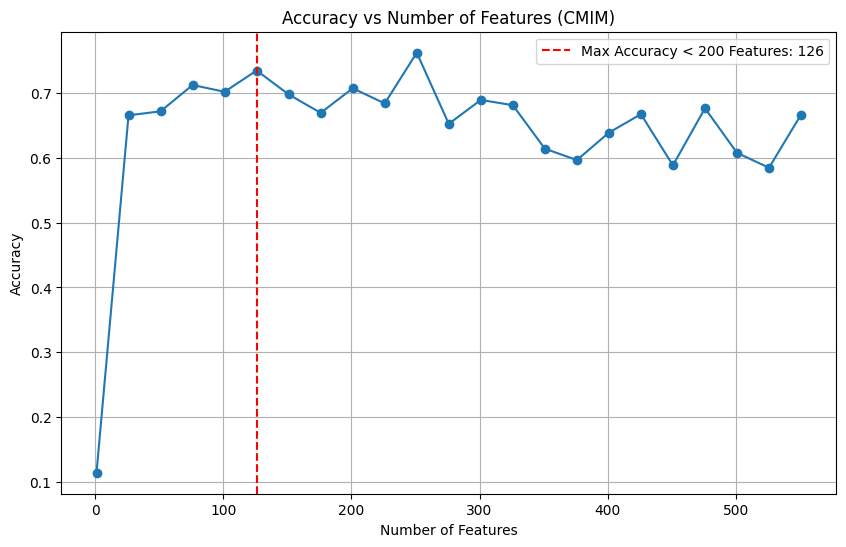

In [100]:
max_accuracy_under_200 = 0
best_num_features_under_200 = 0
for num_features, accuracy in zip(num_features_list_cmim, accuracy_list_cmim):
    if num_features < 200 and accuracy > max_accuracy_under_200:
        max_accuracy_under_200 = accuracy
        best_num_features_under_200 = num_features

# Plot the final graph with vertical line
plt.figure(figsize=(10, 6))
plt.xlabel('Number of Features')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Number of Features (CMIM)')
plt.grid(True)
plt.plot(num_features_list_cmim, accuracy_list_cmim, marker='o')
plt.axvline(x=best_num_features_under_200, color='r', linestyle='--', label=f'Max Accuracy < 200 Features: {best_num_features_under_200:.0f}')
plt.legend()
plt.show()

## Sparse Learning Based

### GOSCAR

In [5]:
def goscar_loss(beta, X, y, lambda1, lambda2):
    """
    Loss function for GOSCAR regularization.
    """
    residual = y - np.dot(X, beta)
    l1_norm = np.sum(np.abs(beta))
    pairwise_penalty = np.sum(np.abs(beta)[:, None] + np.abs(beta)[None, :]) - np.sum(np.abs(beta))  # Optimized group penalty
    return np.sum(residual**2) / 2 + lambda1 * l1_norm + lambda2 * pairwise_penalty

# Solve the GOSCAR optimization problem
def goscar_feature_selection(X, y, lambda1=0.1, lambda2=0.1):
    """
    Perform GOSCAR feature selection.
    """
    n_features = X.shape[1]
    initial_beta = np.zeros(n_features)
    result = minimize(
        goscar_loss,
        initial_beta,
        args=(X, y, lambda1, lambda2),
        method="L-BFGS-B",
        options={"disp": False},
    )
    return result.x  # Optimized coefficients


In [77]:
lambda1, lambda2 = 0.5, 0.5  # Adjusted based on experimentation
goscar_coefficients = goscar_feature_selection(X_scaled, y_encoded, lambda1=lambda1, lambda2=lambda2)

In [28]:
# Select features
threshold = 1e-2
selected_features = np.where(np.abs(goscar_coefficients) > threshold)[0]
print(f"Selected Features {len(selected_features)}(GOSCAR):", selected_features)

# Subset train and test data
X_train_goscar = X_scaled[:, selected_features]
X_test_goscar = X_test_scaled[:, selected_features]

# Train and evaluate classifier
classifier = RandomForestClassifier(random_state=42, class_weight="balanced")
classifier.fit(X_train_goscar, y_encoded)
y_pred_goscar = classifier.predict(X_test_goscar)

# Evaluate accuracy
accuracy_goscar = accuracy_score(y_test_encoded, y_pred_goscar)
print(f"Accuracy using GOSCAR-Selected Features: {accuracy_goscar:.2f}")

Selected Features (GOSCAR): [  3   4   5   6   7   8   9  10  11  12  13  15  16  19  20  21  25  28
  29  33  37  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  61  62  63  64  66  67  73  74  75  76  77  78
  83  86  92  99 102 103 104 109 113 116 117 123 124 125 126 127 128 129
 134 135 136 139 140 141 145 146 153 154 158 177 182 183 184 185 198 200
 201 202 203 205 206 208 209 210 213 214 215 216 218 219 221 222 223 230
 234 235 236 239 240 241 242 243 244 246 260 265 266 268 269 270 271 272
 273 274 275 276 280 281 284 287 288 289 293 294 295 296 297 302 310 314
 316 324 330 332 333 338 339 342 344 347 350 353 363 366 367 368 369 371
 372 373 374 375 376 395 411 412 418 423 425 426 427 428 429 431 432 433
 434 445 447 449 450 451 453 456 457 474 476 483 488 496 500 502 503 504
 505 507 509 510 511 513 514 523 529 530 531 540 547 552 553 558 559 560]
Accuracy using GOSCAR-Selected Features: 0.90


## Statistical Method

In [11]:
def low_variance_feature_selection(X, threshold):
    variances = np.var(X, axis=0)
    selected_features = np.where(variances > threshold)[0]
    X_selected = X.iloc[:, selected_features]
    return X_selected, selected_features


In [63]:
var = X_train.var()
mean = var.mean()
mean

np.float64(0.24238879578465472)

In [96]:
# Apply low variance feature selection before scaling
thresholds = [0.025, 0.04, 0.05, 0.06, 0.07, 0.1, 0.2, 0.3, 0.4 ,0.5, 0.7]  # Example threshold

best_accuracy_lv = 0
best_num_features_lv = 0
best_model_lv = None
best_threshold = 0

num_features_list_lv = []
accuracy_list_lv = []
threshold_list_lv = []

for threshold in thresholds:
    X_train_low_variance, selected_features = low_variance_feature_selection(X_train, threshold)

    #print("Selected Features (Low Variance):", selected_features)

    # Standardize the selected features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_low_variance)

    # Subset and scale the test data with the same selected features
    X_test_low_variance = X_test.iloc[:, selected_features]
    X_test_scaled = scaler.transform(X_test_low_variance)

    # Train and evaluate the classifier
    classifier = RandomForestClassifier(random_state=42, class_weight="balanced")
    classifier.fit(X_train_scaled, y_encoded)
    y_pred_low_variance = classifier.predict(X_test_scaled)

    # Evaluate accuracy
    accuracy_low_variance = accuracy_score(y_test_encoded, y_pred_low_variance)
    print(f"Theshold: {threshold} accuracy: {accuracy_low_variance:.2f}, number of features: {X_train_low_variance.shape[1]}")

    num_features_list_lv.append(X_train_low_variance.shape[1])
    accuracy_list_lv.append(accuracy_low_variance)
    threshold_list_lv.append(threshold)

    if accuracy_low_variance > best_accuracy_lv:
        best_accuracy_lv = accuracy_low_variance
        best_num_features_lv = len(selected_features)
        best_threshold = threshold
        best_model_lv = classifier

print(f"Best number of features: {best_num_features_lv}")
print(f"Best accuracy: {best_accuracy_lv:.2f}")

Theshold: 0.025 accuracy: 0.92, number of features: 455
Theshold: 0.04 accuracy: 0.92, number of features: 407
Theshold: 0.05 accuracy: 0.92, number of features: 370
Theshold: 0.06 accuracy: 0.92, number of features: 326
Theshold: 0.07 accuracy: 0.91, number of features: 286
Theshold: 0.1 accuracy: 0.90, number of features: 190
Theshold: 0.2 accuracy: 0.89, number of features: 60
Theshold: 0.3 accuracy: 0.87, number of features: 29
Theshold: 0.4 accuracy: 0.83, number of features: 18
Theshold: 0.5 accuracy: 0.54, number of features: 6
Theshold: 0.7 accuracy: 0.17, number of features: 1
Best number of features: 455
Best accuracy: 0.92


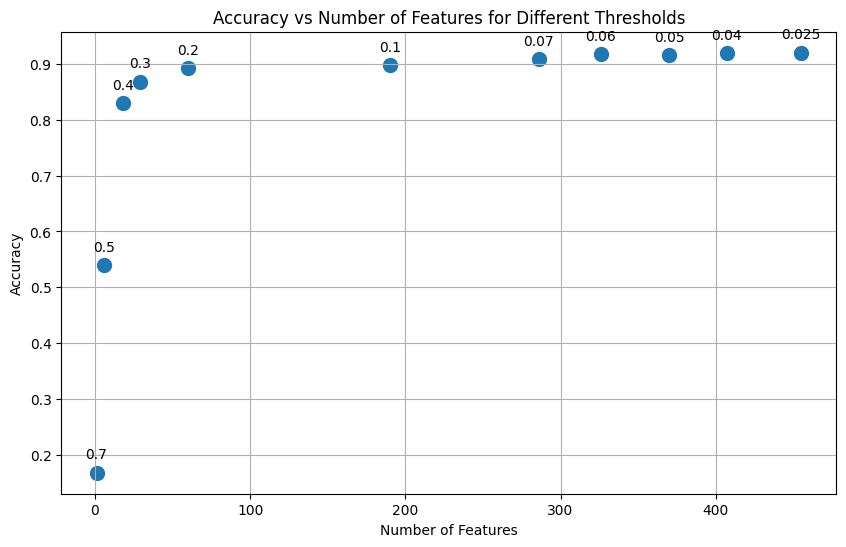

In [97]:
plt.figure(figsize=(10, 6))
plt.scatter(num_features_list_lv, accuracy_list_lv, s=100)

for i, threshold in enumerate(threshold_list_lv):
    plt.annotate(f'{threshold}', (num_features_list_lv[i], accuracy_list_lv[i]), textcoords="offset points", xytext=(0,10), ha='center')

plt.xlabel('Number of Features')
plt.ylabel('Accuracy')
plt.grid()
plt.title('Accuracy vs Number of Features for Different Thresholds')
plt.show()

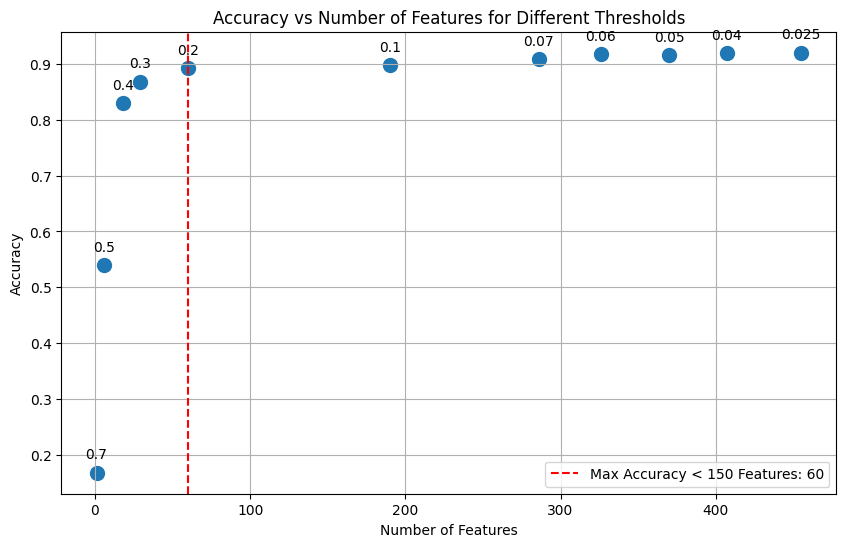

In [98]:
# Find the maximum accuracy where number of features < 150
max_accuracy_under = 0
best_num_features_under = 0
for num_features, accuracy in zip(num_features_list_lv, accuracy_list_lv):
    if num_features < 150 and accuracy > max_accuracy_under:
        max_accuracy_under = accuracy
        best_num_features_under = num_features

# Plot the final graph with vertical line
plt.figure(figsize=(10, 6))
plt.scatter(num_features_list_lv, accuracy_list_lv, s=100)

for i, threshold in enumerate(threshold_list_lv):
    plt.annotate(f'{threshold}', (num_features_list_lv[i], accuracy_list_lv[i]), textcoords="offset points", xytext=(0,10), ha='center')

plt.axvline(x=best_num_features_under, color='r', linestyle='--', label=f'Max Accuracy < 150 Features: {best_num_features_under:.0f}')
plt.xlabel('Number of Features')
plt.ylabel('Accuracy')
plt.grid()
plt.title('Accuracy vs Number of Features for Different Thresholds')
#plt.axvline(x=best_num_features_under, color='r', linestyle='--', label=f'Max Accuracy < 200 Features: {best_num_features_under:.0f}')
plt.legend()
plt.show()

## Evaluate Best model

## On cherche à maximiser l'accuracy

In [42]:
import numpy as np
import time
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

# Assume X and y are predefined datasets
# Feature indices based on selected features
ranked_features = feature_ranking(lap_score(X_scaled, W=W))
top_laplacian_features = ranked_features[:best_num_features]
X_train_laplacian = X_scaled[:, top_laplacian_features]

fisher_scores = fisher_score(X_scaled, y_encoded)
ranked_features_fisher = feature_ranking(fisher_scores)
top_fisher_features = ranked_features_fisher[:best_num_features_fisher]
X_train_fisher = X_scaled[:, top_fisher_features]

X_train_cmim = X_scaled[:, selected_features_cmim[:best_num_features_cmim]]

X_train_low_variance, selected_features = low_variance_feature_selection(X_train, threshold=best_threshold)

# Initialize classifier
clf = RandomForestClassifier(random_state=42)

# Perform cross-validation
start_time = time.time()
cv_laplacian = cross_val_score(clf, X_train_laplacian, y_encoded, cv=5, scoring='accuracy').mean()
time_laplacian = time.time() - start_time
start_time = time.time()
cv_fisher = cross_val_score(clf, X_train_fisher, y_encoded, cv=5, scoring='accuracy').mean()
time_fisher = time.time() - start_time
start_time = time.time()
cv_goscar = cross_val_score(clf, X_train_goscar, y_encoded, cv=5, scoring='accuracy').mean()
time_goscar = time.time() - start_time
start_time = time.time()
cv_cmim = cross_val_score(clf, X_train_cmim, y_encoded, cv=5, scoring='accuracy').mean()
time_cmim = time.time() - start_time
start_time = time.time()
cv_low_variance = cross_val_score(clf, X_train_low_variance, y_encoded, cv=5, scoring='accuracy').mean()
time_low_variance = time.time() - start_time
start_time = time.time()
cv_all = cross_val_score(clf, X_train, y_encoded, cv=5, scoring='accuracy').mean()
time_all = time.time() - start_time
# Compare the results
print("Cross-Validation Accuracy:")
print(f"Laplacian Features: {cv_laplacian:.3f}, reduction features {((1-X_train_laplacian.shape[1]/X_train.shape[1])*100):1f}%, time {time_laplacian:.1f}")
print(f"Fisher Features: {cv_fisher:.3f}, reduction features {((1-X_train_fisher.shape[1]/X_train.shape[1])*100):1f}%, time {time_fisher:.1f}")
print(f"GOSCAR Features: {cv_goscar:.3f}, reduction features {((1-X_train_goscar.shape[1]/X_train.shape[1])*100):1f}%, time {time_goscar:.1f}")
print(f"CMIM Features: {cv_cmim:.3f}, reduction features {((1-X_train_cmim.shape[1]/X_train.shape[1])*100):1f}%, time {time_cmim:.1f}")
print(f"Low Variance Features: {cv_low_variance:.3f}, reduction features {((1-X_train_low_variance.shape[1]/X_train.shape[1])*100):1f}%, time {time_low_variance:.1f}")
print(f"All Features: {cv_all:.3f}, reduction features 0%, time {time_all:.3f}")

Cross-Validation Accuracy:
Laplacian Features: 0.904, reduction features 19.750890%, time 30.810
Fisher Features: 0.912, reduction features 46.441281%, time 21.438
GOSCAR Features: 0.911, reduction features 61.565836%, time 17.832
CMIM Features: 0.917, reduction features 15.302491%, time 28.025
Low Variance Features: 0.914, reduction features 19.039146%, time 28.135
All Features: 0.917, reduction features 0%, time 30.855


## Valeur optimale entre réduction de features et accuracy

In [54]:
import numpy as np
import time
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

# Assume X and y are predefined datasets
# Feature indices based on selected features
ranked_features = feature_ranking(lap_score(X_scaled, W=W))
X_train_laplacian = X_scaled[:, ranked_features[:225]]

ranked_features_fisher = feature_ranking(fisher_scores)
X_train_fisher = X_scaled[:, ranked_features_fisher[:best_num_features_fisher]]

X_train_cmim = X_scaled[:, selected_features_cmim[:126]]

X_train_low_variance, selected_features = low_variance_feature_selection(X_train, threshold=0.07)

# Initialize classifier
clf = RandomForestClassifier(random_state=42)

# Perform cross-validation
start_time = time.time()
cv_laplacian = cross_val_score(clf, X_train_laplacian, y_encoded, cv=5, scoring='accuracy').mean()
time_laplacian = time.time() - start_time
start_time = time.time()
cv_fisher = cross_val_score(clf, X_train_fisher, y_encoded, cv=5, scoring='accuracy').mean()
time_fisher = time.time() - start_time
start_time = time.time()
cv_goscar = cross_val_score(clf, X_train_goscar, y_encoded, cv=5, scoring='accuracy').mean()
time_goscar = time.time() - start_time
start_time = time.time()
cv_cmim = cross_val_score(clf, X_train_cmim, y_encoded, cv=5, scoring='accuracy').mean()
time_cmim = time.time() - start_time
start_time = time.time()
cv_low_variance = cross_val_score(clf, X_train_low_variance, y_encoded, cv=5, scoring='accuracy').mean()
time_low_variance = time.time() - start_time
start_time = time.time()
cv_all = cross_val_score(clf, X_train, y_encoded, cv=5, scoring='accuracy').mean()
time_all = time.time() - start_time
# Compare the results
print("Cross-Validation Accuracy:")
print(f"Laplacian Features: {cv_laplacian:.3f}, reduction features {((1-X_train_laplacian.shape[1]/X_train.shape[1])*100):1f}%, time {time_laplacian:.1f}")
print(f"Fisher Features: {cv_fisher:.3f}, reduction features {((1-X_train_fisher.shape[1]/X_train.shape[1])*100):1f}%, time {time_fisher:.1f}")
print(f"GOSCAR Features: {cv_goscar:.3f}, reduction features {((1-X_train_goscar.shape[1]/X_train.shape[1])*100):1f}%, time {time_goscar:.1f}")
print(f"CMIM Features: {cv_cmim:.3f}, reduction features {((1-X_train_cmim.shape[1]/X_train.shape[1])*100):1f}%, time {time_cmim:.1f}")
print(f"Low Variance Features: {cv_low_variance:.3f}, reduction features {((1-X_train_low_variance.shape[1]/X_train.shape[1])*100):1f}%, time {time_low_variance:.1f}")
print(f"All Features: {cv_all:.3f}, reduction features 0%, time {time_all:.3f}")

Cross-Validation Accuracy:
Laplacian Features: 0.876, reduction features 59.964413%, time 24.8
Fisher Features: 0.912, reduction features 46.441281%, time 21.6
GOSCAR Features: 0.911, reduction features 61.565836%, time 18.0
CMIM Features: 0.917, reduction features 82.206406%, time 14.1
Low Variance Features: 0.912, reduction features 49.110320%, time 21.0
All Features: 0.917, reduction features 0%, time 31.351
